# Panel Regression End-to-End Tutorial

The goal of this notebook is to generate the values needed to plug into the DAX formulas in Power BI so that we can answer the question:

> If a client rents out an X amount of thingmajigs (sales), how much revenue can we expect them to have if we also took account their tenure with the company?

## ENVIRONMENT

In [37]:
# For reproducibility
import random
random.seed(493)

# For manipulating dataframes
import pandas as pd
import numpy as np

# For EDA
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# For Modeling
# from sklearn.model_selection import train_test_split

# To print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

## GET THE DATA

In [2]:
df_sales = pd.read_csv('sales.csv')
df_revenue = pd.read_csv('revenue.csv')

In [ ]:
df_sales.head()

In [ ]:
df_revenue.head()

## PREPARE THE DATA

In [3]:
# First, melt both DataFrames from wide to long format
df_sales_long = df_sales.melt(id_vars='client', var_name='year', value_name='sales')
df_revenue_long = df_revenue.melt(id_vars='client', var_name='year', value_name='revenue')

# Merge sales and revenue on client-year
df_merged = pd.merge(df_sales_long, df_revenue_long, on=['client', 'year'], how='outer')

# Convert year to int (if needed)
df_merged['year'] = df_merged['year'].astype(int)

# Calculate years_in_contract per client
years_in_contract = (
    df_merged.dropna(subset=['sales', 'revenue'], how='all')
    .groupby('client')['year']
    .count()
    .reset_index(name='tenure')
)

# Merge the contract length back into the main DataFrame
df_merged = pd.merge(df_merged, years_in_contract, on='client', how='left')


In [4]:
df_merged.head()

,client,year,sales,revenue,tenure
0,"Adams, Blair and Moyer",2000,NaN,NaN,7
1,"Adams, Blair and Moyer",2001,NaN,NaN,7
2,"Adams, Blair and Moyer",2002,NaN,NaN,7
3,"Adams, Blair and Moyer",2003,NaN,NaN,7
4,"Adams, Blair and Moyer",2004,NaN,NaN,7


In [5]:
df = df_merged.dropna(subset=['sales', 'revenue'], how='any')
df = df.sort_values(by=['client', 'year']).reset_index(drop=True)

In [7]:
df.head(20)

,client,year,sales,revenue,tenure
0,"Adams, Blair and Moyer",2007,994542.0,1.000000e+07,7
1,"Adams, Blair and Moyer",2008,999176.0,1.000000e+07,7
2,"Adams, Blair and Moyer",2010,73083.0,6.629948e+05,7
3,"Adams, Blair and Moyer",2011,204396.0,4.117553e+06,7
4,"Adams, Blair and Moyer",2012,101315.0,1.252215e+06,7
5,"Adams, Blair and Moyer",2022,910181.0,1.000000e+07,7
6,"Adams, Blair and Moyer",2023,164593.0,3.698112e+06,7
7,"Allen, Martinez and Young",2004,726141.0,9.732006e+06,3
8,"Allen, Martinez and Young",2005,695993.0,1.000000e+07,3
9,"Allen, Martinez and Young",2022,767184.0,1.000000e+07,3


In [9]:
missing_counts = df.isna().sum()
missing_counts

client     0
year       0
sales      0
revenue    0
tenure     0
dtype: int64

## EXPLORATORY DATA ANALYSIS

In [20]:
def style_plot(ax=None):
    if ax is None:
        ax = plt.gca()

    def human_format(num):
        abs_num = abs(num)
        if abs_num >= 1_000_000_000:
            return f'{num/1_000_000_000:.1f}B'
        elif abs_num >= 1_000_000:
            return f'{num/1_000_000:.1f}M'
        elif abs_num >= 1_000:
            return f'{num/1_000:.1f}K'
        else:
            return f'{num:.1f}'

    # Format y-axis with K/M/B
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: human_format(x)))

    # Format x-axis (leave years unformatted if likely to be years)
    is_year_axis = all(isinstance(label, (int, float)) and 1900 <= label <= 2100 for label in ax.get_xticks())
    if not is_year_axis:
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: human_format(x)))

    # General aesthetics
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_title(ax.get_title(), fontsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    ax.legend(fontsize=11, loc='best')
    plt.tight_layout()

### Descriptive Statistics

In [10]:
# Overall descriptive stats
df.describe()

,year,sales,revenue,tenure
count,731.000000,731.000000,7.310000e+02,731.000000
mean,2012.641587,541061.165527,7.321717e+06,7.555404
std,7.167478,271549.695300,2.992326e+06,2.623003
min,2000.000000,50321.000000,5.000000e+04,1.000000
25%,2007.000000,312614.500000,5.005594e+06,6.000000
50%,2012.000000,546010.000000,8.474387e+06,8.000000
75%,2019.000000,788966.500000,1.000000e+07,10.000000
max,2025.000000,999504.000000,1.000000e+07,12.000000


- The median revenue is higher than the average, which means some clients or years are pulling the average down. This could be from underperforming years or because revenue can’t go above $10M.
- Sales are more balanced — the average and median are almost the same — so the sales values are more evenly distributed.
- A lot of clients hit the $10M revenue cap, especially in the top 25%, which shows that revenue is maxing out for many clients.
- Most clients are around for a long time. The typical client stays 8 years, and 75% stay at least 6 years, which gives plenty of data for long-term analysis.
- Sales don’t drop very low — the minimum is around $50K — so there aren’t many tiny or noisy contracts.
- Revenue varies a lot, with a standard deviation of about $3M, or 40% of the average, meaning there’s a wide range of outcomes likely influenced by client tenure and other external factors.

In [11]:
# Per-client average sales and revenue
client_avg = df.groupby('client')[['sales', 'revenue']].mean()

# Descriptive stats across clients
client_avg.describe()

,sales,revenue
count,120.000000,1.200000e+02
mean,547246.768952,7.457468e+06
std,141280.489025,1.567923e+06
min,127706.250000,1.432480e+06
25%,461166.250000,6.575945e+06
50%,534720.037500,7.489083e+06
75%,630347.312500,8.328604e+06
max,958256.000000,1.000000e+07


- There are 120 different clients in the dataset, each with at least one year of complete data.
- On average, clients have about $547K in sales and $7.46M in revenue.
- Revenue is much higher than sales, which suggests each sale brings in a lot of added value.
- Sales vary a lot across clients, from about $128K to nearly $1M.
- Revenue also varies, but most clients earn at least $1.4M, and 25% make more than $8.3M.
- Revenue and sales both show some spread, with revenue fluctuating about 21% from the average and sales about 26%.
- Almost all clients bring in solid revenue, with only a few on the lower end.
- The highest revenue values hit a cap at $10M, and a lot of clients are clustered near that limit.

### Time Trends

In [28]:
# Aggregate mean sales and revenue per year
df_trends = df.groupby('year')[['sales', 'revenue']].mean().reset_index()

# Optional: rolling average for smoothing (e.g., 3-year)
df_trends['sales_rolling'] = df_trends['sales'].rolling(window=3, center=True).mean()
df_trends['revenue_rolling'] = df_trends['revenue'].rolling(window=3, center=True).mean()

<Figure size 1200x800 with 0 Axes>

Text(0.5, 1.0, 'Average Sales and Revenue Over Time')

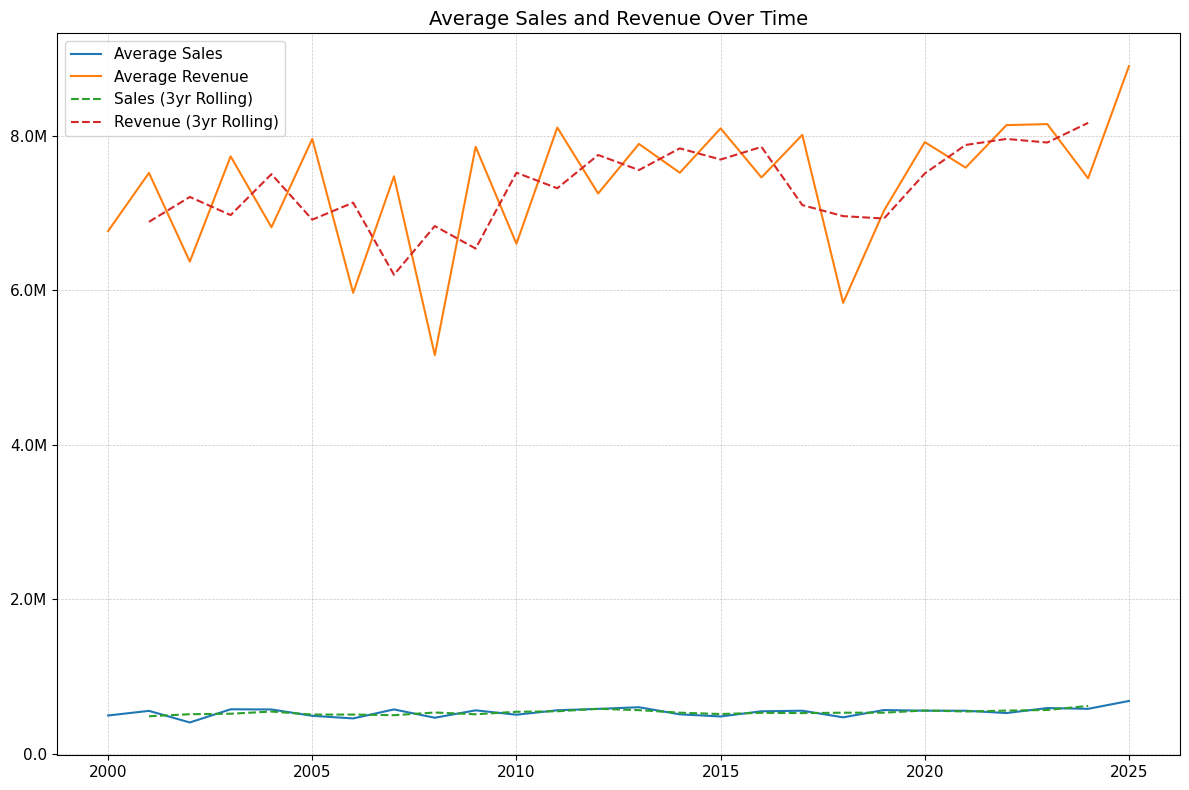

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(df_trends['year'], df_trends['sales'], label='Average Sales')
plt.plot(df_trends['year'], df_trends['revenue'], label='Average Revenue')
plt.plot(df_trends['year'], df_trends['sales_rolling'], linestyle='--', label='Sales (3yr Rolling)')
plt.plot(df_trends['year'], df_trends['revenue_rolling'], linestyle='--', label='Revenue (3yr Rolling)')
plt.title('Average Sales and Revenue Over Time')
style_plot()
plt.show()

- Revenue goes up and down more from year to year than sales do, meaning it's less stable.
- Overall, revenue has been growing, especially after 2018.
- When we smooth the revenue data using a 3-year average, it shows steady growth starting around 2010.
- Sales stay fairly steady over time, with only small increases or decreases.
- The gap between sales and revenue is getting bigger, which could mean the business is getting more value out of each sale.
- Revenue dropped around 2008–2009 and again in 2017, which might be due to outside economic factors.

<Figure size 1200x800 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Growth Rate (%)')

Text(0.5, 1.0, 'Year-over-Year Growth in Average Sales and Revenue')

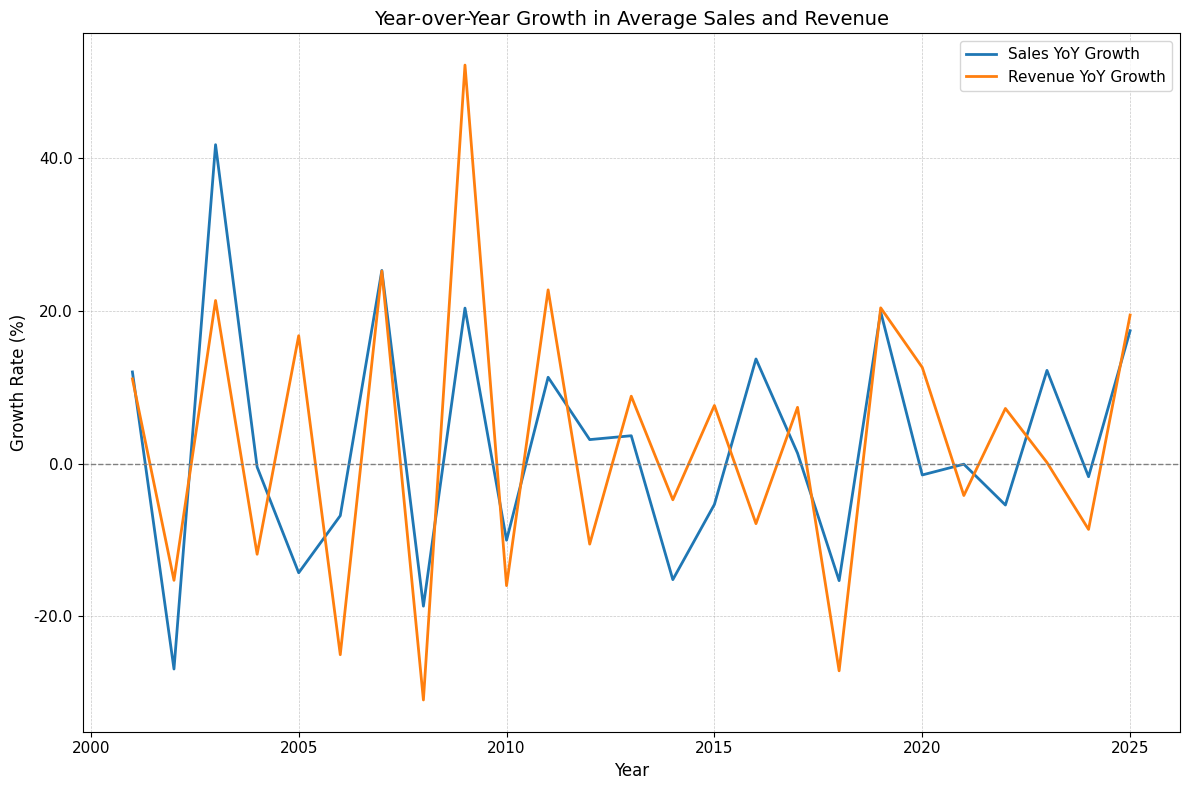

In [30]:
df_growth = df.groupby('year')[['sales', 'revenue']].mean().pct_change() * 100

plt.figure(figsize=(12, 8))
plt.plot(df_growth.index, df_growth['sales'], label='Sales YoY Growth', linewidth=2)
plt.plot(df_growth.index, df_growth['revenue'], label='Revenue YoY Growth', linewidth=2)

ax = plt.gca()
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xlabel('Year')
ax.set_ylabel('Growth Rate (%)')
ax.set_title('Year-over-Year Growth in Average Sales and Revenue')
style_plot(ax)
plt.show()

- Sales and revenue growth change a lot from year to year, without a steady upward or downward trend.
- Revenue tends to swing more than sales, with bigger increases and steeper drops.
- There are several years with large gains (over 40%) and large losses (over -30%), which shows that performance can be very unpredictable.
- Around 2009 and again near 2018–2019, both sales and revenue dropped sharply, which might point to broader economic or industry issues.
- In most years, sales and revenue move in the same direction, but not always — sometimes one increases while the other decreases.
- Overall, the business performance across years is quite uneven, and any forecasts should account for this level of volatility.

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Standard Deviation')

Text(0.5, 1.0, 'Yearly Volatility in Sales and Revenue')

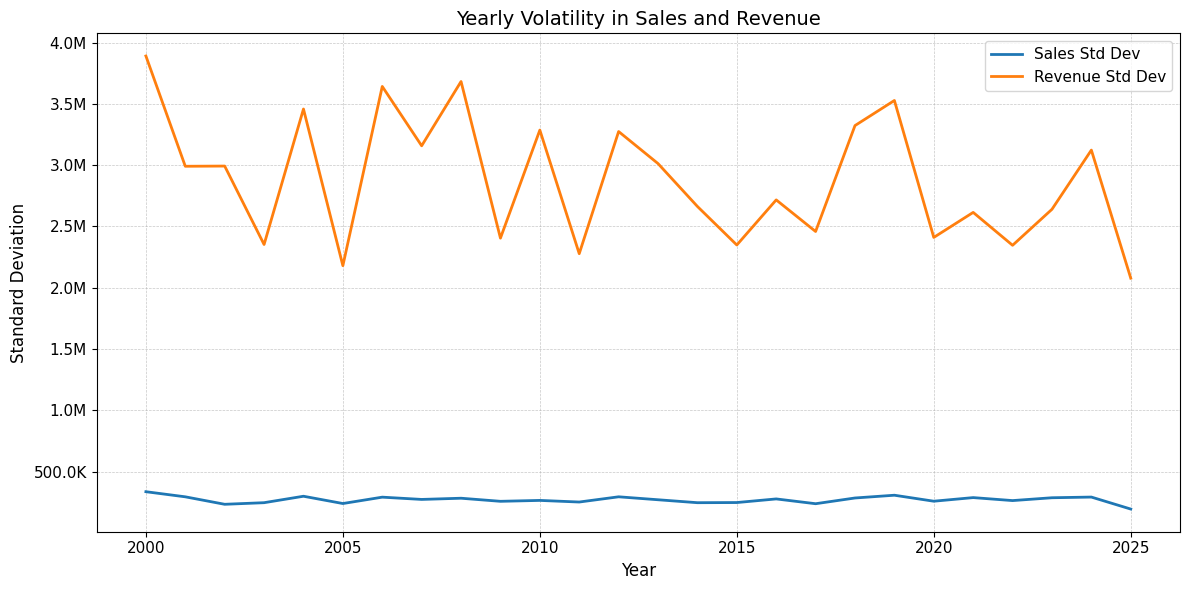

In [31]:
# Compute standard deviation of sales and revenue by year
df_std = df.groupby('year')[['sales', 'revenue']].std().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_std['year'], df_std['sales'], label='Sales Std Dev', linewidth=2)
plt.plot(df_std['year'], df_std['revenue'], label='Revenue Std Dev', linewidth=2)

ax = plt.gca()
ax.set_xlabel('Year')
ax.set_ylabel('Standard Deviation')
ax.set_title('Yearly Volatility in Sales and Revenue')
style_plot(ax)
plt.show()

- Revenue shows much more year-to-year volatility than sales — the standard deviation is several million dollars in most years.
- Sales volatility stays consistently low over time, with only small changes in standard deviation across years.
- Revenue volatility spikes in a few years, like 2000, 2007, 2012, and 2019, which may reflect unusual client behavior or external events in those years.
- Even in calmer years, revenue variation across clients is still much higher than for sales, suggesting revenue is influenced by more unpredictable factors.
- Overall, revenue is more variable and harder to predict than sales on a year-to-year basis.


<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Total Value')

Text(0.5, 1.0, 'Total Sales and Revenue by Year')

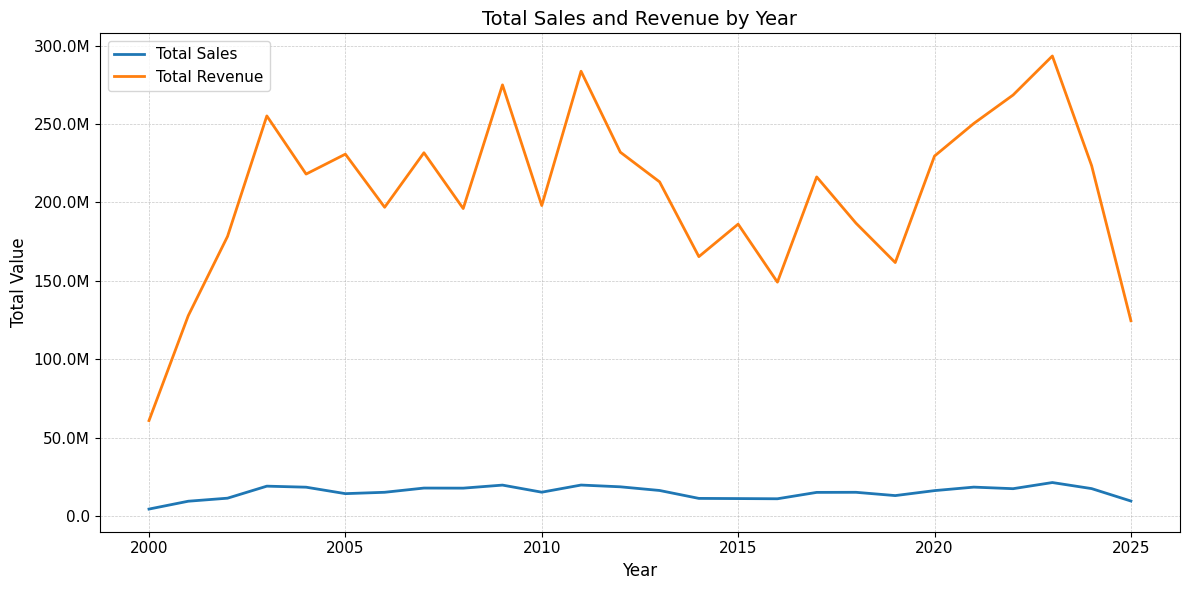

In [33]:
# Calculate total sales and revenue by year
df_totals = df.groupby('year')[['sales', 'revenue']].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_totals['year'], df_totals['sales'], label='Total Sales', linewidth=2)
plt.plot(df_totals['year'], df_totals['revenue'], label='Total Revenue', linewidth=2)

ax = plt.gca()
ax.set_xlabel('Year')
ax.set_ylabel('Total Value')
ax.set_title('Total Sales and Revenue by Year')
style_plot(ax)
plt.show()

- Total revenue rises quickly from 2000 to 2003, then stays high with some year-to-year ups and downs.
- There are noticeable drops in total revenue around 2014 and again in 2024–2025, suggesting fewer or less valuable contracts in those years.
- Total sales follow a similar shape but at a much smaller scale, with totals ranging from about $5M to $25M.
- Sales remain relatively stable over time, while revenue moves more sharply, showing that revenue is more sensitive to changes in client mix or performance.
- The jump in revenue in the early 2000s may reflect a rapid onboarding of clients or a shift to larger deals.
- The pattern suggests that while the number of sales or contract sizes stay steady, the revenue per sale may be increasing or fluctuating more.

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Number of Clients')

Text(0.5, 1.0, 'Number of Active Clients by Year')

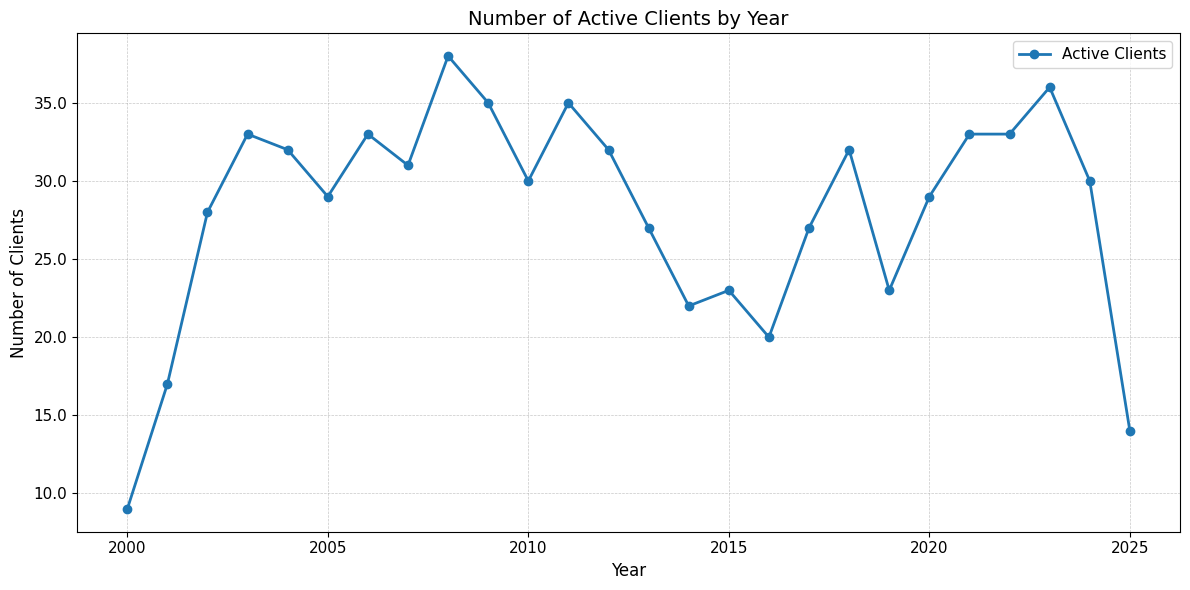

In [34]:
# Calculate number of unique clients per year
df_clients_per_year = df.groupby('year')['client'].nunique().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_clients_per_year['year'], df_clients_per_year['client'], marker='o', linewidth=2, label='Active Clients')

ax = plt.gca()
ax.set_xlabel('Year')
ax.set_ylabel('Number of Clients')
ax.set_title('Number of Active Clients by Year')
style_plot(ax)
plt.show()

- The number of active clients increased sharply from 2000 to 2003, suggesting early growth or onboarding of new clients.
- From 2004 to around 2013, the number of active clients stayed relatively stable, mostly between 30 and 35.
- There was a drop in active clients from 2013 to 2016, with the lowest point around 2016.
- Client count rebounded after 2016 and peaked again around 2023 before declining sharply in 2025.
- The dip in 2025 may indicate clients completing contracts, churn, or a lack of new engagements that year.
- Overall, the business seems to maintain a fairly steady base of around 30–35 clients per year, with only a few high and low outliers.


### Sales-Revenue Relationship

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='sales', ylabel='revenue'>

Text(0.5, 1.0, 'Sales vs. Revenue')

Text(0.5, 0, 'Sales')

Text(0, 0.5, 'Revenue')

C:\Users\Dd\AppData\Local\Temp\ipykernel_27540\1930325663.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=11, loc='best')


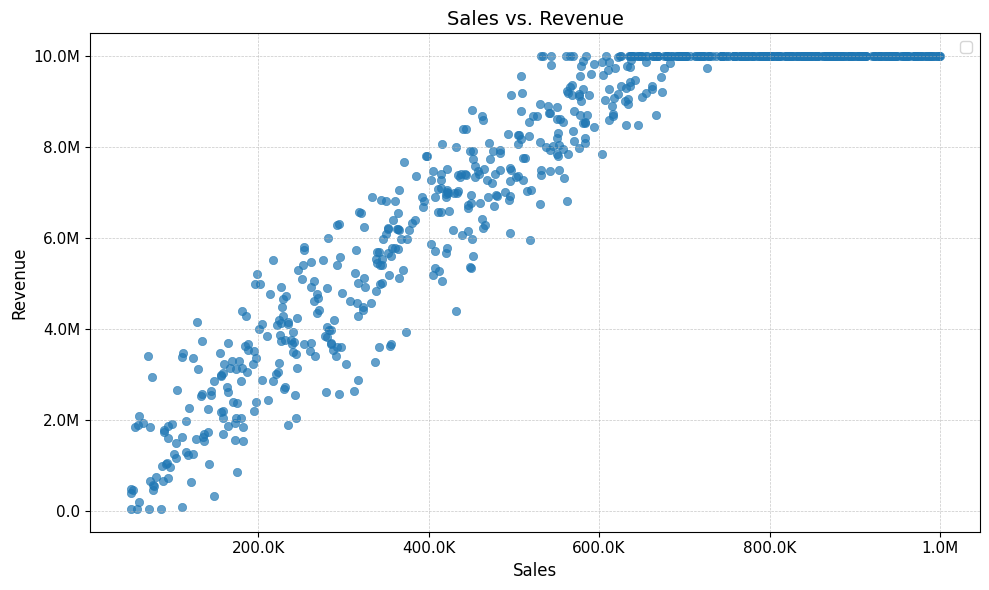

In [38]:
# Scatterplot: sales vs. revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='sales', y='revenue', alpha=0.7, edgecolor=None)
plt.title('Sales vs. Revenue')
plt.xlabel('Sales')
plt.ylabel('Revenue')
style_plot()
plt.show()

- There's a clear positive relationship between sales and revenue — as sales increase, revenue also increases.
- The relationship looks mostly linear until revenue hits around $10M, where many points flatten out, likely due to a revenue cap.
- The pattern is fairly tight, meaning sales and revenue are strongly correlated with relatively low scatter.
- The upper-right corner shows a "ceiling effect" where revenue no longer grows despite increasing sales.
- This suggests the revenue model may have a maximum cap or threshold that's commonly reached by high-performing clients.


In [47]:
# Compute correlation between sales and revenue
sales_revenue_corr = df[['sales', 'revenue']].corr().iloc[0, 1]

# Create a new column for revenue per sale
df['revenue_per_sale'] = df['revenue'] / df['sales']

# Summary statistics for revenue per sale
revenue_per_sale_summary = df['revenue_per_sale'].describe()

revenue_per_sale_summary = revenue_per_sale_summary.apply(lambda x: round(x, 2))
sales_revenue_corr = round(sales_revenue_corr, 4)

print(revenue_per_sale_summary)
print(sales_revenue_corr)

count    731.00
mean      14.43
std        4.18
min        0.58
25%       11.78
50%       14.10
75%       16.32
max       47.95
Name: revenue_per_sale, dtype: float64
0.9233


- The average revenue per dollar of sales is about 14.43, meaning for every $1 in sales, clients generate roughly $14.43 in revenue.
- This ratio varies across clients and years — the standard deviation is 4.18, showing moderate spread.
- Most values fall between about 11.78 and 16.32, suggesting a fairly consistent multiplier for most clients.
- The lowest observed ratio is 0.58, indicating a case where revenue was unusually low compared to sales.
- The highest ratio is nearly 48, showing that in some cases, revenue is much higher than sales — likely driven by tenure, quality, or other boosting factors.
- The correlation between sales and revenue is 0.9233, which is very strong. This confirms that sales are a major driver of revenue, but not the only one.


### Client-level behavior

<Figure size 1400x600 with 0 Axes>

<BarContainer object of 120 artists>

Text(0.5, 0, 'Client (sorted by years active)')

Text(0, 0.5, 'Years Active')

Text(0.5, 1.0, 'Number of Years Each Client Was Active')

C:\Users\Dd\AppData\Local\Temp\ipykernel_27540\1930325663.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=11, loc='best')


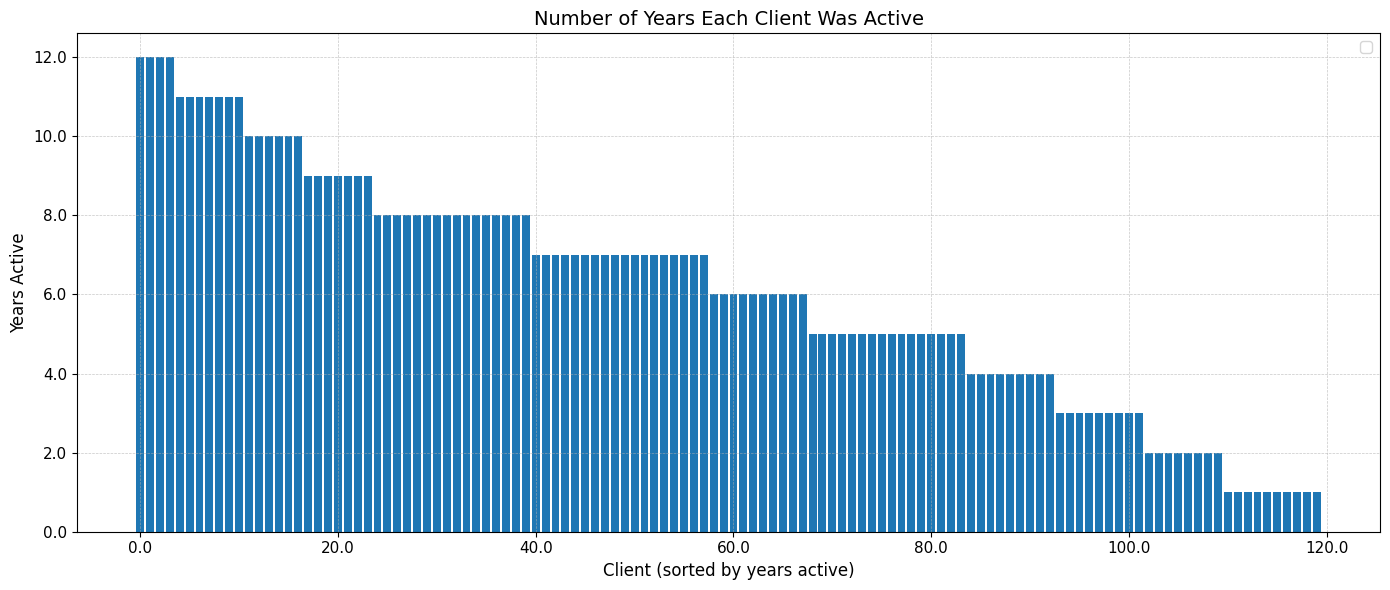

In [51]:
# Calculate how many years each client was active
client_years = df.groupby('client')['year'].nunique().reset_index(name='years_active')

# Sort by years_active for plotting
client_years_sorted = client_years.sort_values(by='years_active', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(14, 6))
plt.bar(client_years_sorted.index, client_years_sorted['years_active'])
plt.xlabel('Client (sorted by years active)')
plt.ylabel('Years Active')
plt.title('Number of Years Each Client Was Active')
ax = plt.gca()
style_plot(ax)
plt.show()

> Replace above with the fancy smancy one from work!

In [ ]:
# Histogram of average revenue per sale by client
client_efficiency = df.groupby('client')['revenue_per_sale'].mean().reset_index(name='avg_revenue_per_sale')

In [32]:
# Get unique client IDs
unique_clients = df['client'].unique()

# Split client IDs into train and test
train_clients, test_clients = train_test_split(
    unique_clients, test_size=0.2, random_state=493
)

# Create train/test sets by filtering on client
train_df = df[df['client'].isin(train_clients)].copy()
test_df = df[df['client'].isin(test_clients)].copy()

NameError: name 'train_test_split' is not defined

In [ ]:
# Check missing values in train_df
print("Missing values in train_df:")
print(train_df.isna().sum())

# Check missing values in test_df
print("\nMissing values in test_df:")
print(test_df.isna().sum())

# Optionally, show number of rows with any missing values
print(f"\nRows with any missing values in train_df: {train_df.isna().any(axis=1).sum()}")
print(f"Rows with any missing values in test_df: {test_df.isna().any(axis=1).sum()}")

In [ ]:
# Drop rows with missing values before modeling
train_df = train_df.dropna(subset=['sales', 'number_years_in_contract', 'revenue'])

# Drop rows with missing values before modeling
test_df = test_df.dropna(subset=['sales', 'number_years_in_contract', 'revenue'])

In [ ]:
# Fit models using cleaned data
from linearmodels.panel import PooledOLS, PanelOLS, RandomEffects
import statsmodels.api as sm

# Prepare clean training data
train_df_clean = train_df.dropna(subset=['sales', 'number_years_in_contract', 'revenue']).copy()

train_df_clean = train_df.dropna(subset=['sales', 'number_years_in_contract', 'revenue']).copy()

# Reset index if already set
if train_df_clean.index.names == ['client', 'year']:
    train_df_clean = train_df_clean.reset_index()

# Now safely set the multi-index
train_df_clean = train_df_clean.set_index(['client', 'year'])

# Variables
exog_vars = ['sales', 'number_years_in_contract']
exog = sm.add_constant(train_df_clean[exog_vars])
endog = train_df_clean['revenue']

# Fit models
pooled_ols = PooledOLS(endog, exog).fit(cov_type='robust')
fe_model = PanelOLS(endog, train_df_clean[exog_vars], entity_effects=True, time_effects=True, drop_absorbed=True).fit(cov_type='robust')
re_model = RandomEffects(endog, exog).fit(cov_type='robust')

# Compare model fit
fit_comparison = pd.DataFrame({
    'Model': ['Pooled OLS', 'Fixed Effects', 'Random Effects'],
    'R-squared': [
        pooled_ols.rsquared,
        getattr(fe_model.rsquared, 'within', fe_model.rsquared),  # fallback
        re_model.rsquared
    ],
    'Log-Likelihood': [pooled_ols.loglik, fe_model.loglik, re_model.loglik]
})

fit_comparison

In [ ]:
# Rescale sales and revenue to make units manageable (divide by 1,000)
train_df['sales'] = train_df['sales'] / 1000
train_df['revenue'] = train_df['revenue'] / 1000
test_df['sales'] = test_df['sales'] / 1000
test_df['revenue'] = test_df['revenue'] / 1000

# Re-run fixed effects evaluation
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Clean and reindex training data
train_df_clean = train_df.dropna(subset=['sales', 'years_active', 'revenue']).copy()
if train_df_clean.index.names != ['client', 'year']:
    train_df_clean = train_df_clean.set_index(['client', 'year'])

# Fit Fixed Effects model
exog_vars = ['sales', 'years_active']
fe_model = PanelOLS(train_df_clean['revenue'], train_df_clean[exog_vars], entity_effects=True).fit()

# Extract coefficients
coeffs = fe_model.params

# Predict on test set
X_test = test_df[['sales', 'years_active']].copy()
y_test = test_df['revenue'].copy()
y_pred = np.dot(X_test, coeffs.values)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"Test R-squared (structural only): {r2:.4f}")
print(f"Test RMSE (in thousands): {rmse:,.2f}")

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted revenue
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Revenue (in thousands)')
plt.ylabel('Predicted Revenue (in thousands)')
plt.title('Fixed Effects Model: Predicted vs Actual Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
